In [105]:
import pydotplus
import pandas as pd
import numpy  as np
import sklearn.metrics
from io import StringIO
from sklearn import tree
from IPython.display import Image
from collections import defaultdict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [106]:
# import data 

data = pd.read_csv("2013to2017.csv", usecols=[9, 10, 11, 12, 15, 17])
data.columns = ["Home", "Home Pts", "Visitor", "Visitor Pts", "Win TO", "Lose TO"]

In [107]:
data.head(3)

,Home,Home Pts,Visitor,Visitor Pts,Win TO,Lose TO
0,Denver Broncos,49,Baltimore Ravens,27,2,2
1,Cleveland Browns,10,Miami Dolphins,23,1,3
2,Buffalo Bills,21,New England Patriots,23,3,2


In [108]:
# change all instances of San Diego Chargers and St. Louis Rams to LA

for index, row in data.iterrows():
    if row["Home"] == "St. Louis Rams":
        row["Home"] = "Los Angeles Rams"
    if row["Visitor"] == "St. Louis Rams":
        row["Visitor"] = "Los Angeles Rams"
    if row["Home"] == "San Diego Chargers":
        row["Home"] = "Los Angeles Chargers"
    if row["Visitor"] == "San Diego Chargers":
        row["Visitor"] = "Los Angeles Chargers"
    
    data.iloc[index] = row

In [109]:
# starting accuracy - if you bet solely on the home team every time

data["Home Won"] = (data["Home Pts"] > data["Visitor Pts"])

In [110]:
print("Win percentage: {0:.1f}%".format(100 * data["Home Won"].sum() / data["Home Won"].count()))

Win percentage: 57.2%


In [111]:
# classification class

y_true = data["Home Won"].values

In [112]:
rank = pd.read_csv("rank.csv", usecols=[0, 1])

In [113]:
rank.head(5)

,Rank,Team
0,1,Philadelphia Eagles
1,2,New England Patriots
2,3,Minnesota Vikings
3,4,Pittsburgh Steelers
4,5,New Orleans Saints


In [114]:
# who ranks higher

data["Home Ranks Higher"] = 0

for index, row in data.iterrows():
    home = row["Home"]
    visitor = row["Visitor"]
    
    hr = 0
    vr = 0
    for i, r in rank.iterrows():
        if r["Team"] == home:
            hr = r["Rank"]
        elif r["Team"] == visitor:
            vr = r["Rank"]
    
    row["Home Ranks Higher"] = int(hr < vr)
    data.iloc[index] = row

In [115]:
data.head(10)

,Home,Home Pts,Visitor,Visitor Pts,Win TO,Lose TO,Home Won,Home Ranks Higher
0,Denver Broncos,49,Baltimore Ravens,27,2,2,True,0
1,Cleveland Browns,10,Miami Dolphins,23,1,3,False,0
2,Buffalo Bills,21,New England Patriots,23,3,2,False,0
3,Chicago Bears,24,Cincinnati Bengals,21,1,3,True,0
4,Indianapolis Colts,21,Oakland Raiders,17,0,2,True,0
5,Pittsburgh Steelers,9,Tennessee Titans,16,0,2,False,1
6,Detroit Lions,34,Minnesota Vikings,24,2,4,True,0
7,New York Jets,18,Tampa Bay Buccaneers,17,2,2,True,0
8,Jacksonville Jaguars,2,Kansas City Chiefs,28,0,2,False,1
9,New Orleans Saints,23,Atlanta Falcons,17,1,2,True,1


In [116]:
# who is on winning streak

data["Home Win Streak"] = 0
data["Visitor Win Streak"] = 0

streak = defaultdict(int)
for index, row in data.iterrows():
    home = row["Home"]
    visitor = row["Visitor"]
    row["Home Win Streak"] = streak[home]
    row["Visitor Win Streak"] = streak[visitor]
    
    data.iloc[index] = row
    
    # current win
    
    if row["Home Won"]:
        streak[home] += 1
        streak[visitor] = 0
    else:
        streak[visitor] += 1
        streak[home] = 0

In [117]:
# pick features

X_features = data[["Home Ranks Higher"]].values

# build tree

clf = DecisionTreeClassifier(random_state=14)

scores = cross_val_score(clf, X_features, y_true, scoring='accuracy')
print(scores)
print("Accuracy: {0:.1f}%".format(np.mean(scores) * 100))

[ 0.51569507  0.55505618  0.57207207]
Accuracy: 54.8%


In [118]:
# who has less turnovers

data["Home Less TO"] = 0

for index, row in data.iterrows():
    hTO = 0
    vTO = 0
    
    if row["Home Won"]:
        hTO = row["Win TO"]
        vTO = row["Lose TO"]
    else:
        hTO = row["Lose TO"]
        vTO = row["Win TO"]
    
    row["Home Less TO"] = int(hTO < vTO)
    data.iloc[index] = row

In [119]:
data.head(5)

,Home,Home Pts,Visitor,Visitor Pts,Win TO,Lose TO,Home Won,Home Ranks Higher,Home Win Streak,Visitor Win Streak,Home Less TO
0,Denver Broncos,49,Baltimore Ravens,27,2,2,True,0,0,0,0
1,Cleveland Browns,10,Miami Dolphins,23,1,3,False,0,0,0,0
2,Buffalo Bills,21,New England Patriots,23,3,2,False,0,0,0,1
3,Chicago Bears,24,Cincinnati Bengals,21,1,3,True,0,0,0,1
4,Indianapolis Colts,21,Oakland Raiders,17,0,2,True,0,0,0,1


In [120]:
# pick features

X_features = data[["Home Ranks Higher", "Home Win Streak", "Home Less TO"]].values

# build tree

clf = DecisionTreeClassifier(random_state=14)

scores = cross_val_score(clf, X_features, y_true, scoring='accuracy')
print(scores)
print("Accuracy: {0:.1f}%".format(np.mean(scores) * 100))

[ 0.69955157  0.6741573   0.72297297]
Accuracy: 69.9%


In [121]:
# who won last time they both played each other regardless of home vs. visiting

data["Home Won Last"] = 0

last = defaultdict(int)

for index, row in data.iterrows():
    home = row["Home"]
    visitor = row["Visitor"]
    pair = tuple(sorted([home, visitor]))
    
    if last[pair] == row["Home Won"]:
        row["Home Won Last"] = 1
    else:
        row["Home Won Last"] = 0
    
    data.iloc[index] = row
    
    # current game
    
    last[pair] = 0
    if row["Home Won"] == 0:
        last[pair] = 1

In [122]:
# pick features

X_features = data[["Home Ranks Higher", "Home Win Streak", "Home Less TO", "Home Won Last"]].values

# build tree

clf = DecisionTreeClassifier(random_state=14)

scores = cross_val_score(clf, X_features, y_true, scoring='accuracy')
print(scores)
print("Accuracy: {0:.1f}%".format(np.mean(scores) * 100))

[ 0.79372197  0.73707865  0.69594595]
Accuracy: 74.2%


In [123]:
data.head(10)

,Home,Home Pts,Visitor,Visitor Pts,Win TO,Lose TO,Home Won,Home Ranks Higher,Home Win Streak,Visitor Win Streak,Home Less TO,Home Won Last
0,Denver Broncos,49,Baltimore Ravens,27,2,2,True,0,0,0,0,0
1,Cleveland Browns,10,Miami Dolphins,23,1,3,False,0,0,0,0,1
2,Buffalo Bills,21,New England Patriots,23,3,2,False,0,0,0,1,1
3,Chicago Bears,24,Cincinnati Bengals,21,1,3,True,0,0,0,1,0
4,Indianapolis Colts,21,Oakland Raiders,17,0,2,True,0,0,0,1,0
5,Pittsburgh Steelers,9,Tennessee Titans,16,0,2,False,1,0,0,0,1
6,Detroit Lions,34,Minnesota Vikings,24,2,4,True,0,0,0,1,0
7,New York Jets,18,Tampa Bay Buccaneers,17,2,2,True,0,0,0,0,0
8,Jacksonville Jaguars,2,Kansas City Chiefs,28,0,2,False,1,0,0,0,1
9,New Orleans Saints,23,Atlanta Falcons,17,1,2,True,1,0,0,1,0


In [124]:
# who averages less turnovers vs. their opponents

rank["Avg Less TO"] = 0
rank["Games"] = 0

for index, row in data.iterrows():
    home = row["Home"]
    visitor = row["Visitor"]
    
    for i, r in rank.iterrows():
        if r["Team"] == home:
            r["Games"] += 1
            if row["Home Less TO"]:
                r["Avg Less TO"] += 1
        if r["Team"] == visitor:
            r["Games"] += 1
            if row["Home Less TO"]:
                r["Avg Less TO"] += 1
        
        rank.iloc[i] = r

data["Home Avgs Less TO"] = 0
        
for index, row in data.iterrows():
    home = row["Home"]
    visitor = row["Visitor"]
    
    h = 0.0
    v = 0.0
    for i, r in rank.iterrows():
        if r["Team"] == home:
            h = float(r["Avg Less TO"] / r["Games"])
        elif r["Team"] == visitor:
            v = float(r["Avg Less TO"] / r["Games"])
    
    print("home: ", home, " ", h)
    print("visitor ", visitor, " ", v)
    print(int(h > v))
    row["Home Avgs Less TO"] = int(h > v)
    
    data.iloc[index] = row
    
    if index == 5: break

home:  Denver Broncos   0.3793103448275862
visitor  Baltimore Ravens   0.5
0
home:  Cleveland Browns   0.4625
visitor  Miami Dolphins   0.4074074074074074
1
home:  Buffalo Bills   0.41975308641975306
visitor  New England Patriots   0.4731182795698925
0
home:  Chicago Bears   0.3875
visitor  Cincinnati Bengals   0.3253012048192771
1
home:  Indianapolis Colts   0.4
visitor  Oakland Raiders   0.43209876543209874
0
home:  Pittsburgh Steelers   0.41379310344827586
visitor  Tennessee Titans   0.35365853658536583
1


In [125]:
data.head(5)

,Home,Home Pts,Visitor,Visitor Pts,Win TO,Lose TO,Home Won,Home Ranks Higher,Home Win Streak,Visitor Win Streak,Home Less TO,Home Won Last,Home Avgs Less TO
0,Denver Broncos,49,Baltimore Ravens,27,2,2,True,0,0,0,0,0,0
1,Cleveland Browns,10,Miami Dolphins,23,1,3,False,0,0,0,0,1,1
2,Buffalo Bills,21,New England Patriots,23,3,2,False,0,0,0,1,1,0
3,Chicago Bears,24,Cincinnati Bengals,21,1,3,True,0,0,0,1,0,1
4,Indianapolis Colts,21,Oakland Raiders,17,0,2,True,0,0,0,1,0,0


In [171]:
# pick features

X_features = data[["Home Ranks Higher", "Home Win Streak", "Home Less TO", "Home Won Last", "Home Avgs Less TO"]].values

# build tree

clf = DecisionTreeClassifier(random_state=14)

scores = cross_val_score(clf, X_features, y_true, scoring='accuracy')
print(scores)
print("Accuracy: {0:.1f}%".format(np.mean(scores) * 100))

[ 0.79372197  0.73707865  0.69594595]
Accuracy: 74.2%


In [180]:
pred_train, pred_test, tar_train, tar_test = train_test_split(X_features, y_true, test_size=0.33)

# build and train tree using data

clf = DecisionTreeClassifier(min_samples_leaf=20)
clf = clf.fit(pred_train, tar_train)

preds = clf.predict(pred_test)

# confusion matrix

sklearn.metrics.confusion_matrix(tar_test, preds)
sklearn.metrics.accuracy_score(tar_test, preds)
print("Accuracy: {0:.1f}%".format(sklearn.metrics.accuracy_score(tar_test, preds) * 100))

Accuracy: 78.0%


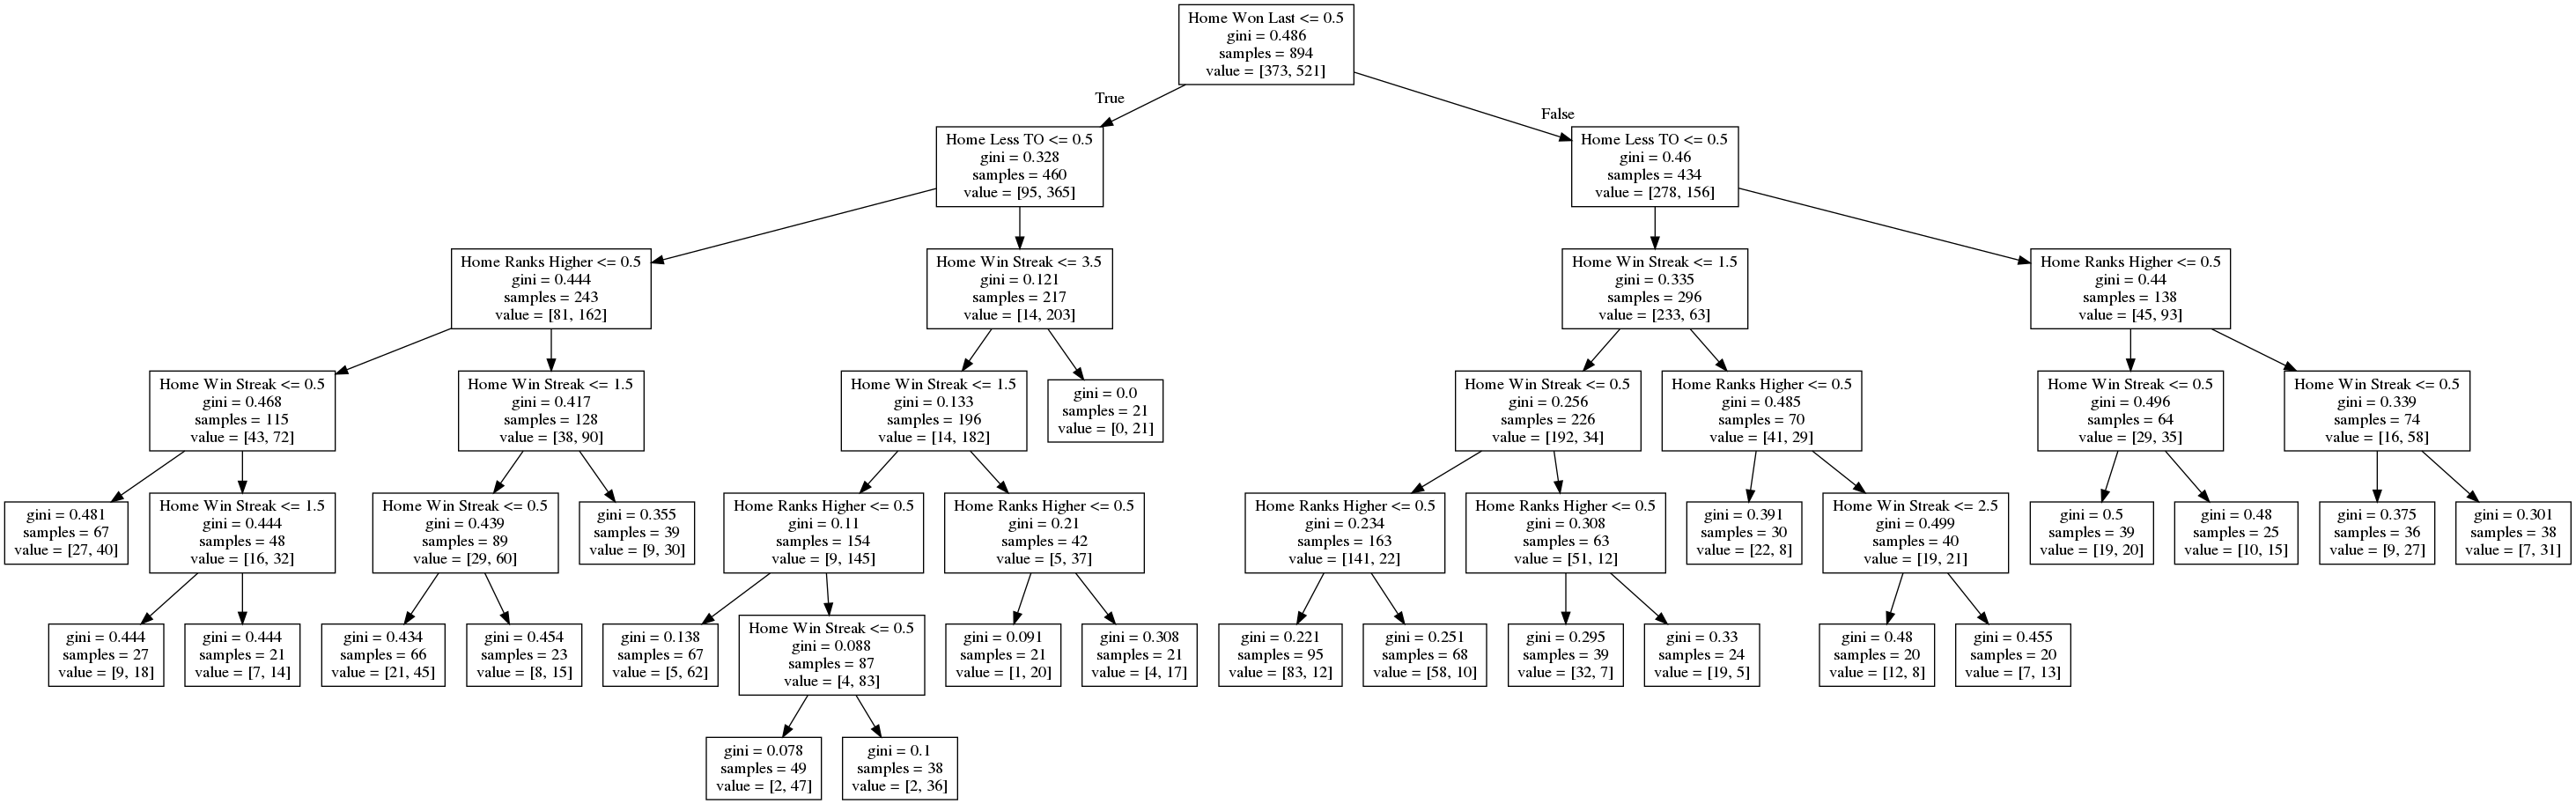

In [184]:
# output decision tree

out = StringIO()
tree.export_graphviz(clf, out_file=out, feature_names=["Home Ranks Higher", "Home Win Streak", "Home Less TO", "Home Won Last", "Home Avgs Less TO"])
graph=pydotplus.graph_from_dot_data(out.getvalue())
Image(graph.create_png())

In [187]:
# translate tree into code
# code from https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [188]:
f = ["Home Ranks Higher", "Home Win Streak", "Home Less TO", "Home Won Last", "Home Avgs Less TO"]
tree_to_code(clf, f)

def tree(Home Ranks Higher, Home Win Streak, Home Less TO, Home Won Last, Home Avgs Less TO):
  if Home Won Last <= 0.5:
    if Home Less TO <= 0.5:
      if Home Ranks Higher <= 0.5:
        if Home Win Streak <= 0.5:
          return [[ 27.  40.]]
        else:  # if Home Win Streak > 0.5
          if Home Win Streak <= 1.5:
            return [[  9.  18.]]
          else:  # if Home Win Streak > 1.5
            return [[  7.  14.]]
      else:  # if Home Ranks Higher > 0.5
        if Home Win Streak <= 1.5:
          if Home Win Streak <= 0.5:
            return [[ 21.  45.]]
          else:  # if Home Win Streak > 0.5
            return [[  8.  15.]]
        else:  # if Home Win Streak > 1.5
          return [[  9.  30.]]
    else:  # if Home Less TO > 0.5
      if Home Win Streak <= 3.5:
        if Home Win Streak <= 1.5:
          if Home Ranks Higher <= 0.5:
            return [[  5.  62.]]
          else:  # if Home Ranks Higher > 0.5
            if Home Win Streak <= 0.5:
    